# ライブラリインストール

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi
from lifelines.utils import concordance_index
from sklearn.preprocessing import StandardScaler
import warnings
from typing import Tuple, Optional, Union
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.family'] = 'MS Gothic'
sns.set_style("whitegrid")

# 関数

In [81]:
def generate_medical_survival_data(n: int = 500, seed: int = 42) -> pd.DataFrame:
    """医療研究を模擬した生存分析データを生成する。
    
    現実的な医療データの特徴を持つ模擬データセットを作成します。
    年齢、治療法、病期、バイオマーカーを共変量として含み、
    これらの要因が生存時間に与える影響を設定済みです。

    バイオマーカーとは、生物体内で特定の状態や変化を示す指標となる物質や現象のことです。具体的には、疾患の有無、病状の進行、治療の効果などを客観的に評価するために用いられます.
    
    生存時間の分布にワイブル分布を採用する理由:
        1. 現実的なハザード関数:
           - shape > 1: 時間とともにリスクが増加（老化効果）
           - shape < 1: 時間とともにリスクが減少（初期故障型）
           - shape = 1: 一定ハザード（指数分布と同等）
        
        2. 医療データの特徴:
           - 多くの疾患で時間とともにリスクが変化
           - より現実的な生存曲線を生成
        
        3. Cox回帰の学習効果:
           - 複雑なハザード構造でもCox回帰が適切に機能することを確認
           - 比例ハザード仮定の重要性がより明確に
        
        4. 統計的な妥当性:
           - ワイブル分布は生存分析で広く使用される標準的な分布
           - 指数分布の一般化として理論的に整合
    
    Args:
        n: 生成するサンプル数。デフォルトは500。
        seed: 乱数シード。再現性確保のため。デフォルトは42。
    
    Returns:
        以下の列を含むDataFrame:
            - duration: 生存時間（月）
            - event: イベント発生フラグ（1=死亡/再発、0=打ち切り）
            - age: 年齢（20-90歳）
            - treatment: 治療法（0=標準治療、1=新治療）
            - stage: 病期（1-4の整数）
            - biomarker: バイオマーカー値（対数正規分布）
    
    Examples:
        >>> df = generate_medical_survival_data(n=100, seed=123)
        >>> print(df.head())
        >>> print(f"イベント発生率: {df['event'].mean():.2%}")
    """
    np.random.seed(seed)
    
    # 共変量の生成
    age = np.random.normal(65, 12, n)  # 年齢: 平均65歳、標準偏差12
    age = np.clip(age, 20, 90)  # 20-90歳に制限
    
    treatment = np.random.binomial(1, 0.5, n)  # 治療法: 50%で新治療
    
    stage = np.random.choice([1, 2, 3, 4], n, p=[0.2, 0.3, 0.3, 0.2])  # 病期
    
    biomarker = np.random.lognormal(0, 0.5, n)  # バイオマーカー（対数正規分布）
    
    # ハザード比を設定（Cox回帰の真の係数）
    beta_age = 0.02        # 年齢1歳増加でハザード比1.02
    beta_treatment = -0.4  # 新治療でハザード比0.67（保護効果）
    beta_stage = 0.3       # 病期1段階上昇でハザード比1.35
    beta_biomarker = 0.5   # バイオマーカー1単位増加でハザード比1.65
    
    # 線形予測子の計算
    linear_predictor = (beta_age * age + 
                       beta_treatment * treatment + 
                       beta_stage * stage + 
                       beta_biomarker * biomarker)
    
    # ワイブル分布から生存時間を生成（より現実的なハザード関数）
    scale = 50  # スケールパラメータ
    shape = 1.2  # 形状パラメータ（>1で時間とともにハザード増加）
    
    # ワイブル分布による生存時間の生成
    # 線形予測子を考慮したスケールパラメータの調整
    adjusted_scale = scale * np.exp(-linear_predictor / shape)
    duration = np.random.weibull(shape, n) * adjusted_scale
    
    # 打ち切り時間の生成（観察期間の終了など）
    censoring_time = np.random.uniform(30, 120, n)  # 30-120ヶ月
    
    # 実際の観察時間とイベント発生の決定
    observed_duration = np.minimum(duration, censoring_time)
    event = (duration <= censoring_time).astype(int)
    
    # データフレームの作成
    df = pd.DataFrame({
        'duration': observed_duration,
        'event': event,
        'age': age,
        'treatment': treatment,
        'stage': stage,
        'biomarker': biomarker
    })
    
    return df

In [82]:
def perform_cox_analysis(df: pd.DataFrame) -> CoxPHFitter:
    """Cox比例ハザードモデルの分析を実行し、結果を表示する。
    
    データセットに対してCox回帰分析を実行し、以下の結果を出力します：
    - データの基本統計
    - Cox回帰モデルの係数とハザード比
    - モデル適合度の評価指標
    
    Args:
        df: 生存分析用データフレーム。'duration'と'event'列が必須。
    
    Returns:
        学習済みのCoxPHFitterオブジェクト。
    
    Raises:
        KeyError: 必要な列（duration, event）が存在しない場合。
        
    Examples:
        >>> df = generate_medical_survival_data()
        >>> cph = perform_cox_analysis(df)
        >>> print(f"Concordance Index: {cph.concordance_index_:.3f}")
    """
    
    print("=" * 60)
    print("Cox比例ハザードモデル分析")
    print("=" * 60)
    
    # データの基本統計
    print("\n1. データの概要")
    print("-" * 30)
    print(f"サンプルサイズ: {len(df)}")
    print(f"イベント発生数: {df['event'].sum()} ({df['event'].mean():.1%})")
    print(f"平均観察期間: {df['duration'].mean():.1f}ヶ月")
    
    print("\n変数の基本統計:")
    print(df.describe().round(2))
    
    # Cox回帰モデルの適合
    print("\n2. Cox回帰モデルの結果")
    print("-" * 30)
    
    cph = CoxPHFitter()
    cph.fit(df, duration_col='duration', event_col='event')
    
    # 結果の表示
    print(cph.summary)
    
    # ハザード比の信頼区間
    print("\n3. ハザード比と95%信頼区間")
    print("-" * 30)
    hr_summary = cph.summary[['coef', 'exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']]
    hr_summary.columns = ['係数', 'ハザード比', 'HR下限', 'HR上限', 'p値']
    print(hr_summary.round(3))
    
    # モデルの適合度
    print("\n4. モデル適合度")
    print("-" * 30)
    print(f"Concordance Index: {cph.concordance_index_:.3f}")
    print(f"Log-likelihood: {cph.log_likelihood_:.2f}")
    print(f"Partial AIC: {cph.AIC_partial_:.2f}")
    print(f"Log-likelihood ratio test p-value: {cph.log_likelihood_ratio_test().p_value:.4f}")
    
    return cph


In [83]:
def visualize_results(df: pd.DataFrame, cph: CoxPHFitter) -> None:
    """Cox回帰分析の結果を可視化する。
    
    4つのプロットを含む図表を作成します：
    1. 治療法別Kaplan-Meier生存曲線
    2. ハザード比とその95%信頼区間
    3. マルチンゲール残差プロット（モデル診断用）
    4. 病期別生存曲線
    
    Args:
        df: 分析対象のデータフレーム。
        cph: 学習済みのCoxPHFitterオブジェクト。
    
    Returns:
        None. 図表をmatplotlibで表示します。
        
    Note:
        この関数はmatplotlib.pyplot.show()を呼び出すため、
        Jupyter環境では%matplotlib inlineが推奨されます。
        
    Examples:
        >>> df = generate_medical_survival_data()
        >>> cph = perform_cox_analysis(df)
        >>> visualize_results(df, cph)
    """
    plt.rcParams['font.family'] = 'Meiryo'
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. 生存曲線（治療法別）
    ax1 = axes[0, 0]
    for treatment in [0, 1]:
        subset = df[df['treatment'] == treatment]
        from lifelines import KaplanMeierFitter
        kmf = KaplanMeierFitter()
        kmf.fit(subset['duration'], subset['event'], 
                label=f'治療法 {"新治療" if treatment else "標準治療"}')
        kmf.plot_survival_function(ax=ax1)
    
    ax1.set_title('治療法別生存曲線')
    ax1.set_xlabel('時間（月）')
    ax1.set_ylabel('生存確率')
    ax1.legend()
    
    # 2. ハザード比のプロット
    ax2 = axes[0, 1]
    summary = cph.summary
    variables = summary.index
    hazard_ratios = summary['exp(coef)']
    lower_ci = summary['exp(coef) lower 95%']
    upper_ci = summary['exp(coef) upper 95%']
    
    y_pos = np.arange(len(variables))
    ax2.errorbar(hazard_ratios, y_pos, 
                xerr=[hazard_ratios - lower_ci, upper_ci - hazard_ratios],
                fmt='o', capsize=5)
    ax2.axvline(x=1, color='red', linestyle='--', alpha=0.7)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(variables)
    ax2.set_xlabel('hazarad ratio')
    ax2.set_title('ハザード比と95%信頼区間')
    ax2.grid(True, alpha=0.3)
    
    # 3. 残差プロット
    ax3 = axes[1, 0]
    residuals = cph.compute_residuals(df, kind='martingale') # duration, event, martingaleの列名の500行データフレーム
    # 残差と予測値の長さの確認
    predicted_hazard = cph.predict_partial_hazard(df)
    # インデックスをリセットして残差と予測値を照合する
    residuals_array = residuals['martingale'].values
    predicted_array = np.array(predicted_hazard).flatten()

    ax3.scatter(predicted_array, residuals_array, alpha=0.6)
    ax3.axhline(y=0, color='red', linestyle='--')
    ax3.set_xlabel('予測ハザード')
    ax3.set_ylabel('マルチンゲール残差')
    ax3.set_title('残差プロット')
    
    # 4. 病期別の生存曲線
    ax4 = axes[1, 1]
    for stage in sorted(df['stage'].unique()):
        subset = df[df['stage'] == stage]
        kmf = KaplanMeierFitter()
        kmf.fit(subset['duration'], subset['event'], label=f'病期 {stage}')
        kmf.plot_survival_function(ax=ax4)
    
    ax4.set_title('病期別生存曲線')
    ax4.set_xlabel('時間（月）')
    ax4.set_ylabel('生存確率')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()

In [84]:
def check_proportional_hazards(df: pd.DataFrame, cph: CoxPHFitter) -> None:
    """Cox回帰の比例ハザード仮定をチェックする。
    
    Schoenfeld残差を用いて比例ハザード仮定の検定を行います。
    この仮定が成立しない場合、Cox回帰の結果の解釈に注意が必要です。
    
    Args:
        df: 分析対象のデータフレーム。
        cph: 学習済みのCoxPHFitterオブジェクト。
    
    Returns:
        None. 検定結果をコンソールに出力します。
        
    Note:
        p値 < 0.05の場合、該当する変数で比例ハザード仮定が棄却されます。
        この場合、層別化Cox回帰や時間依存係数モデルの検討が必要です。
        
    Examples:
        >>> df = generate_medical_survival_data()
        >>> cph = perform_cox_analysis(df)
        >>> check_proportional_hazards(df, cph)
    """
    print("\n5. 比例ハザード仮定の検定")
    print("-" * 30)
    
    # Schoenfeld残差による検定
    try:
        test_result = cph.check_assumptions(df, p_value_threshold=0.05)
        print("比例ハザード仮定の検定結果:")
        print("p値 < 0.05 の場合、仮定が棄却される")
        
        # 結果の解釈
        if test_result is not None:
            print("すべての変数で比例ハザード仮定が成立しています。")
        else:
            print("一部の変数で比例ハザード仮定が成立しない可能性があります。")
            
    except Exception as e:
        print(f"検定実行中にエラーが発生: {e}")




In [85]:
def predict_survival(cph: CoxPHFitter, df: pd.DataFrame,exam_df: pd.DataFrame) -> None:
    """個別患者の生存確率を予測する。
    
    3人の代表的な患者プロファイルを用いて、Cox回帰モデルによる
    生存確率の予測例を示します。1年、2年、3年、5年時点での
    生存確率を計算します。
    
    Args:
        cph: 学習済みのCoxPHFitterオブジェクト。
        df: 元の学習データ（予測時の参照用）。
    
    Returns:
        None. 予測結果をコンソールに出力します。
        
    Note:
        部分ハザードが高いほど、生存確率は低くなります。
        この関数は教育目的の例示であり、実際の臨床使用には
        より詳細な検証が必要です。
        
    Examples:
        >>> df = generate_medical_survival_data()
        >>> cph = perform_cox_analysis(df)
        >>> predict_survival(cph, df)
    """
    print("\n6. 個別予測の例")
    print("-" * 30)
    
    print("予測対象患者:")
    print(exam_df)
    
    # 部分ハザードの予測
    partial_hazards = cph.predict_partial_hazard(exam_df)
    print(f"\n部分ハザード: {partial_hazards.values}")
    
    # 特定時点での生存確率
    times = [12, 24, 36, 60]  # 1年, 2年, 3年, 5年
    for i, patient in exam_df.iterrows():
        print(f"\n患者{i+1}の生存確率:")
        survival_func = cph.predict_survival_function(patient.to_frame().T)
        for t in times:
            prob = survival_func.iloc[:, 0].loc[survival_func.index <= t].iloc[-1] if len(survival_func.index[survival_func.index <= t]) > 0 else 1.0
            print(f"  {t}ヶ月: {prob:.3f}")

In [86]:
df = generate_medical_survival_data(n=500,seed=42)
df.head()

,duration,event,age,treatment,stage,biomarker
0,9.262465,1,70.960570,1,4,0.575979
1,14.310748,1,63.340828,1,1,0.340805
2,2.504275,1,72.772262,0,4,1.214448
3,1.319381,1,83.276358,1,1,3.478147
4,22.565068,1,62.190160,1,2,0.996969


In [87]:
cph = perform_cox_analysis(df)
cph

Cox比例ハザードモデル分析

1. データの概要
------------------------------
サンプルサイズ: 500
イベント発生数: 500 (100.0%)
平均観察期間: 6.6ヶ月

変数の基本統計:
       duration  event     age  treatment   stage  biomarker
count    500.00  500.0  500.00      500.0  500.00     500.00
mean       6.58    1.0   64.98        0.5    2.50       1.17
std        6.46    0.0   11.49        0.5    1.03       0.61
min        0.00    1.0   26.10        0.0    1.00       0.23
25%        2.18    1.0   56.60        0.0    2.00       0.74
50%        4.63    1.0   65.15        1.0    3.00       1.03
75%        8.49    1.0   72.64        1.0    3.00       1.45
max       38.00    1.0   90.00        1.0    4.00       4.94

2. Cox回帰モデルの結果
------------------------------
               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
age        0.016697   1.016837  0.003929        0.008996        0.024398   
treatment -0.262014   0.769500  0.092189       -0.442702    

<lifelines.CoxPHFitter: fitted with 500 total observations, 0 right-censored observations>

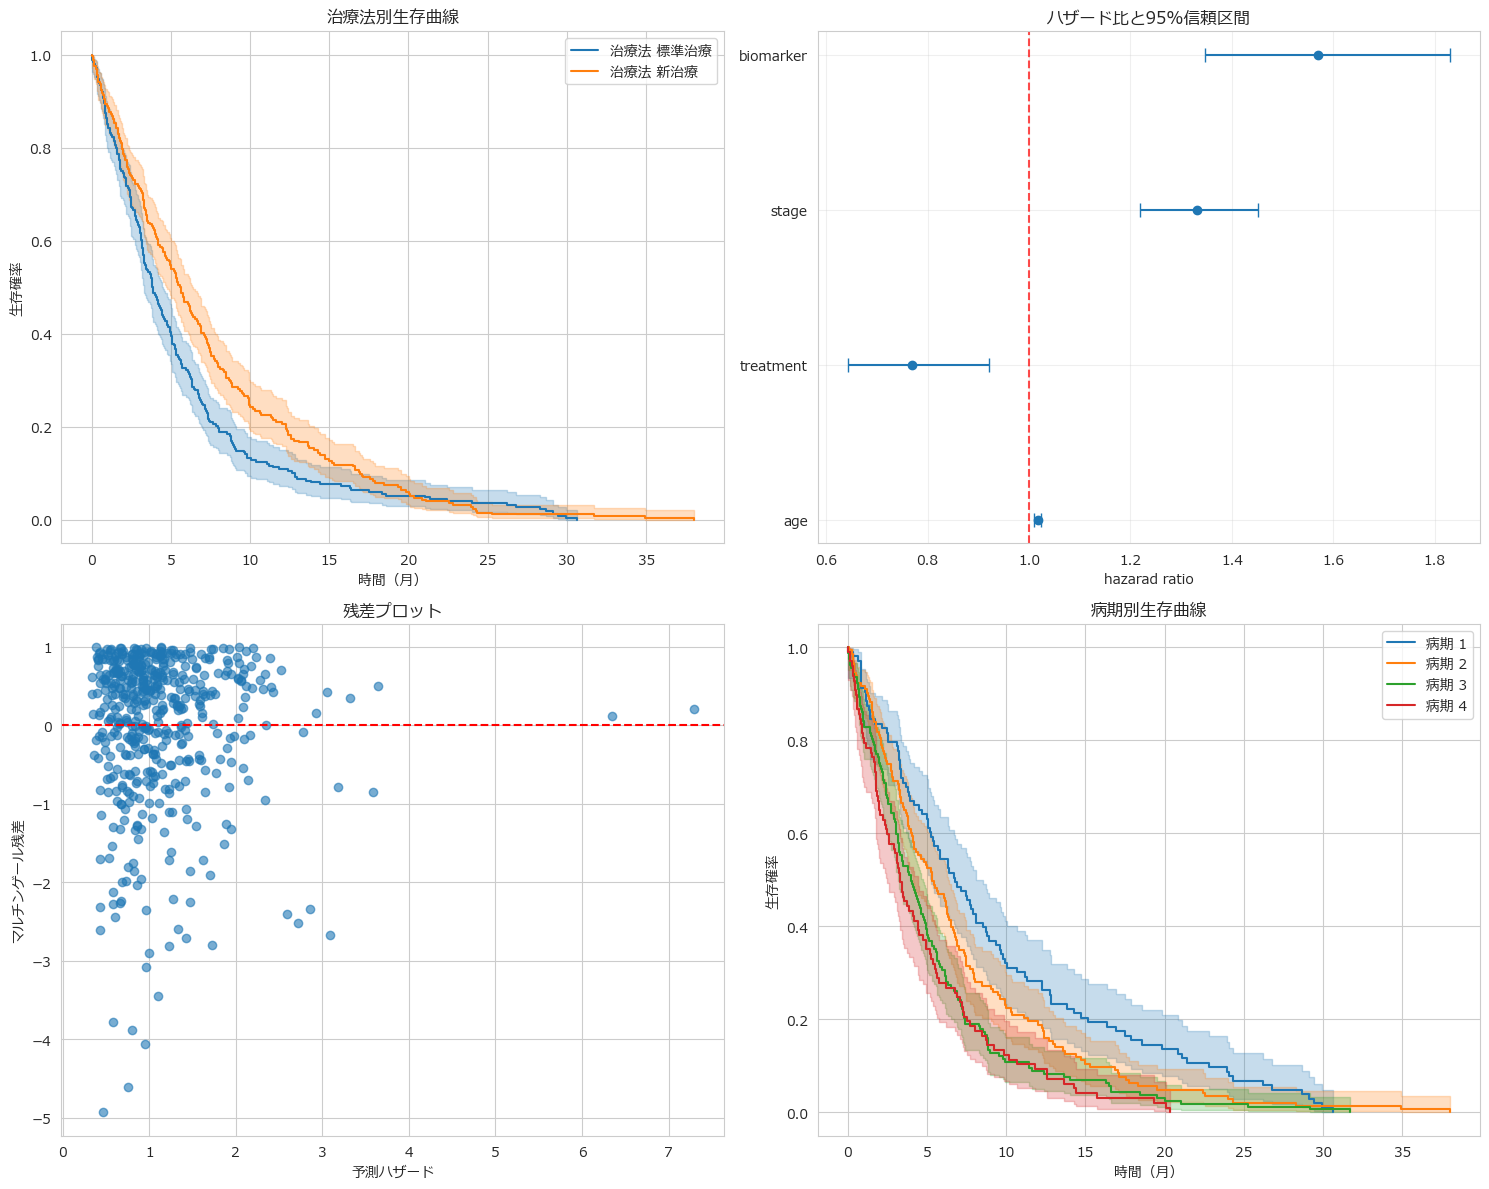

In [88]:
visualize_results(df,cph)

In [89]:
check_proportional_hazards(df,cph)


5. 比例ハザード仮定の検定
------------------------------
Proportional hazard assumption looks okay.
比例ハザード仮定の検定結果:
p値 < 0.05 の場合、仮定が棄却される
すべての変数で比例ハザード仮定が成立しています。


In [90]:
# 代表的な患者プロファイルを作成
exam_df = pd.DataFrame({
        'age': [55, 70, 65],
        'treatment': [0, 1, 1], # 治療をしたか否か
        'stage': [2, 3, 1], # 病状のレベル
        'biomarker': [1.0, 2.0, 0.5] # バイオマーカー。生体内で特定の病状を引き起こす指標となる物質を測定した値
})

In [91]:
print("\n" + "=" * 60)
print("分析完了！")
print("\n重要なポイント:")
print("- ハザード比 > 1: リスク増加要因")
print("- ハザード比 < 1: 保護要因")  
print("- p値 < 0.05: 統計的に有意")
print("- Concordance Index: 予測精度の指標（0.5-1.0）")

predict_survival(cph,df,exam_df)



分析完了！

重要なポイント:
- ハザード比 > 1: リスク増加要因
- ハザード比 < 1: 保護要因
- p値 < 0.05: 統計的に有意
- Concordance Index: 予測精度の指標（0.5-1.0）

6. 個別予測の例
------------------------------
予測対象患者:
   age  treatment  stage  biomarker
0   55          0      2        1.0
1   70          1      3        2.0
2   65          1      1        0.5

部分ハザード: [0.77521236 1.60106057 0.42277918]

患者1の生存確率:
  12ヶ月: 0.209
  24ヶ月: 0.038
  36ヶ月: 0.002
  60ヶ月: 0.000

患者2の生存確率:
  12ヶ月: 0.039
  24ヶ月: 0.001
  36ヶ月: 0.000
  60ヶ月: 0.000

患者3の生存確率:
  12ヶ月: 0.425
  24ヶ月: 0.168
  36ヶ月: 0.030
  60ヶ月: 0.015
